In [1]:
#import packages

import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

### Submission Data

In [173]:
import os
directory = 'TerraLuna'


In [174]:
def process_data(path):
    df=pd.read_csv(path)
    if not(df.empty):
        df['date']=pd.to_datetime(df['created_utc'],unit='s').dt.date
        df = df[['id','subreddit', 'selftext', 'title', 'date', 'author']]
#         df=df.drop('Unnamed: 0', axis=1)
    return df

In [175]:
df_terraluna=pd.DataFrame()

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f) and f.endswith(".csv"):
        df_terraluna=pd.concat([df_terraluna, process_data(f)])

# Drop unneccessary column
df_terraluna=df_terraluna.drop('Unnamed: 0', axis=1)

# Reset Index
df_terraluna=df_terraluna.reset_index()

# Drop Index
df_terraluna=df_terraluna.drop('index', axis=1)

# Remove [removed]
df_terraluna = df_terraluna[df_terraluna.selftext!='[removed]']

# Drop dupes
df_terraluna = df_terraluna.drop_duplicates(subset=['id'])

In [176]:
len(df_terraluna)

8863

In [177]:
df_terraluna=df_terraluna.fillna('')

In [178]:
# Combine title and selftext

df_terraluna['all_text'] = df_terraluna.selftext.astype(str) + ' ' + df_terraluna.title.astype(str)
df_terraluna.head()

,id,subreddit,selftext,title,date,author,all_text
0,ultfvp,CryptoCurrency,,Trader doubles down on $10 million bet against...,2022-05-09,16431879196842.0,Trader doubles down on $10 million bet agains...
2,up76nt,CryptoCurrency,I know people are mostly burnt out on the Terr...,Can someone ELI5: Why does Terra UST have any ...,2022-05-14,AlexAndertheAble,I know people are mostly burnt out on the Terr...
3,up1vfx,CryptoCurrency,Here's a post of someone explaining how UST co...,They've been warned - but they didn't listen.,2022-05-13,ismirschlecht,Here's a post of someone explaining how UST co...
4,uowutl,CryptoCurrency,I'm so depressed that I can't even tell you ho...,terraluna ended my life,2022-05-13,No_Confusion_6801,I'm so depressed that I can't even tell you ho...
5,uovlmu,CryptoCurrency,"As we all know, things have been pretty hairy ...",Which exchange do you trust most at times like...,2022-05-13,Findjin,"As we all know, things have been pretty hairy ..."


In [179]:
# Make text lower
df_terraluna['all_text'] = df_terraluna['all_text'].astype(str).str.lower()
df_terraluna.head()

,id,subreddit,selftext,title,date,author,all_text
0,ultfvp,CryptoCurrency,,Trader doubles down on $10 million bet against...,2022-05-09,16431879196842.0,trader doubles down on $10 million bet agains...
2,up76nt,CryptoCurrency,I know people are mostly burnt out on the Terr...,Can someone ELI5: Why does Terra UST have any ...,2022-05-14,AlexAndertheAble,i know people are mostly burnt out on the terr...
3,up1vfx,CryptoCurrency,Here's a post of someone explaining how UST co...,They've been warned - but they didn't listen.,2022-05-13,ismirschlecht,here's a post of someone explaining how ust co...
4,uowutl,CryptoCurrency,I'm so depressed that I can't even tell you ho...,terraluna ended my life,2022-05-13,No_Confusion_6801,i'm so depressed that i can't even tell you ho...
5,uovlmu,CryptoCurrency,"As we all know, things have been pretty hairy ...",Which exchange do you trust most at times like...,2022-05-13,Findjin,"as we all know, things have been pretty hairy ..."


In [180]:
# count how many submissions per day

pd.pivot_table(df_terraluna, index='date', values='all_text', columns='subreddit', aggfunc='count')

subreddit,Bitcoin,CryptoCurrency,terraluna
date,,,
2022-04-29,NaN,3.0,4.0
2022-04-30,NaN,4.0,14.0
2022-05-01,NaN,9.0,19.0
2022-05-02,NaN,11.0,32.0
2022-05-03,NaN,5.0,29.0
2022-05-04,NaN,2.0,19.0
2022-05-05,2.0,11.0,18.0
2022-05-06,2.0,13.0,22.0
2022-05-07,1.0,5.0,25.0


### Comments Data

In [157]:
df_terraluna_comments = pd.read_csv('TerraLuna comments/terraluna_comments.csv', index_col=0,
                 lineterminator='\n')

# Clean Removed Comments
df_terraluna_comments = df_terraluna_comments[df_terraluna_comments.Comment!='[removed]']

# Get cleaned parent ID
df_terraluna_comments['parent_id_clean']=df_terraluna_comments['Parent ID'].str[3:]

df_terraluna_comments=df_terraluna_comments.rename(columns={"Submission ID": "submission_id"
                                     , "Parent ID": "parent_id"
                                     , "Comment ID": "comment_id"
                                     , "Comment": "comment"
                                     , "Author": 'author'}, errors="raise")

In [158]:
len(df_terraluna_comments)

153446

In [159]:
df_terraluna_comments.head()

,submission_id,parent_id,comment_id,comment,author,parent_id_clean
0,ultfvp,t3_ultfvp,i7yhwgn,This person just made a shit ton of money rn. ...,LSATloveaffair,ultfvp
2,ultfvp,t3_ultfvp,i864dj3,And they’re rich,Dads_going_for_milk,ultfvp
3,ultfvp,t3_ultfvp,i7xgukp,Initially i thought this bet was interesting b...,marsangelo,ultfvp
4,up76nt,t3_up76nt,i8j3fnz,It's still top 50 in marketcap because it has ...,nick83487,up76nt
5,up76nt,t3_up76nt,i8j38nm,"Thank you for submitting to /r/CryptoCurrency,...",ccModBot,up76nt


In [161]:
# Fill NA
df_terraluna_comments=df_terraluna_comments.fillna('')

# Make text lower
df_terraluna_comments['comment'] = df_terraluna_comments['comment'].astype(str).str.lower()

# Get dates
df_terraluna_lookup_date = df_terraluna[['id','date']]
df_terraluna_lookup_date = df_terraluna_lookup_date.set_index("id").loc[:, "date"]
df_terraluna_comments=df_terraluna_comments.assign(date=df_terraluna_comments.submission_id.map(df_terraluna_lookup_date))
df_terraluna_comments.head()

,submission_id,parent_id,comment_id,comment,author,parent_id_clean,date
0,ultfvp,t3_ultfvp,i7yhwgn,this person just made a shit ton of money rn. ...,LSATloveaffair,ultfvp,2022-05-09
2,ultfvp,t3_ultfvp,i864dj3,and they’re rich,Dads_going_for_milk,ultfvp,2022-05-09
3,ultfvp,t3_ultfvp,i7xgukp,initially i thought this bet was interesting b...,marsangelo,ultfvp,2022-05-09
4,up76nt,t3_up76nt,i8j3fnz,it's still top 50 in marketcap because it has ...,nick83487,up76nt,2022-05-14
5,up76nt,t3_up76nt,i8j38nm,"thank you for submitting to /r/cryptocurrency,...",ccModBot,up76nt,2022-05-14


### Clean Submission Data

In [231]:
# NLTK Package and Regex Tokenizer

import nltk
from nltk.tokenize import RegexpTokenizer

regexp = RegexpTokenizer('\w+')

In [238]:
# Replace words meant to be together into one word

df_terraluna['all_text'] = df_terraluna['all_text'].str.replace('crypto.com', 'cryptocom')
df_terraluna['all_text'] = df_terraluna['all_text'].str.replace('do kwon', 'dokwon')
df_terraluna['all_text'] = df_terraluna['all_text'].str.replace("do kwon’s", "dokwon’s")

# Tokenize all_text

df_terraluna['text_token']=df_terraluna['all_text'].apply(regexp.tokenize)

# Get English Stopwords
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words("english")

# Extend the list with custom stopwords
my_stopwords = ['https', 'nan', 'removed', 'amp', 'x200b', 'com', 'www', '000']
stopwords.extend(my_stopwords)

df_terraluna['text_token'] = df_terraluna['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
df_terraluna.head()

<ipython-input-238-e4abe7da844c>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_terraluna['all_text'] = df_terraluna['all_text'].str.replace('crypto.com', 'cryptocom')
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shiltonjonatansalindeho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,subreddit,selftext,title,date,author,all_text,text_token,text_string
0,ultfvp,CryptoCurrency,,Trader doubles down on $10 million bet against...,2022-05-09,16431879196842.0,trader doubles down on $10 million bet agains...,"[trader, doubles, 10, million, bet, dokwon, lu...",trader doubles million bet dokwon luna short p...
2,up76nt,CryptoCurrency,I know people are mostly burnt out on the Terr...,Can someone ELI5: Why does Terra UST have any ...,2022-05-14,AlexAndertheAble,i know people are mostly burnt out on the terr...,"[know, people, mostly, burnt, terraluna, story...",know people mostly burnt terraluna story somet...
3,up1vfx,CryptoCurrency,Here's a post of someone explaining how UST co...,They've been warned - but they didn't listen.,2022-05-13,ismirschlecht,here's a post of someone explaining how ust co...,"[post, someone, explaining, ust, could, depegg...",post someone explaining ust could depegged goo...
4,uowutl,CryptoCurrency,I'm so depressed that I can't even tell you ho...,terraluna ended my life,2022-05-13,No_Confusion_6801,i'm so depressed that i can't even tell you ho...,"[depressed, even, tell, way, describe, much, s...",depressed even tell way describe much sadness ...
5,uovlmu,CryptoCurrency,"As we all know, things have been pretty hairy ...",Which exchange do you trust most at times like...,2022-05-13,Findjin,"as we all know, things have been pretty hairy ...","[know, things, pretty, hairy, crypto, past, we...",know things pretty hairy crypto past week pric...


In [239]:
# Only keep words with length more than 2

df_terraluna['text_string'] = df_terraluna['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
df_terraluna.head()

,id,subreddit,selftext,title,date,author,all_text,text_token,text_string
0,ultfvp,CryptoCurrency,,Trader doubles down on $10 million bet against...,2022-05-09,16431879196842.0,trader doubles down on $10 million bet agains...,"[trader, doubles, 10, million, bet, dokwon, lu...",trader doubles million bet dokwon luna short p...
2,up76nt,CryptoCurrency,I know people are mostly burnt out on the Terr...,Can someone ELI5: Why does Terra UST have any ...,2022-05-14,AlexAndertheAble,i know people are mostly burnt out on the terr...,"[know, people, mostly, burnt, terraluna, story...",know people mostly burnt terraluna story somet...
3,up1vfx,CryptoCurrency,Here's a post of someone explaining how UST co...,They've been warned - but they didn't listen.,2022-05-13,ismirschlecht,here's a post of someone explaining how ust co...,"[post, someone, explaining, ust, could, depegg...",post someone explaining ust could depegged goo...
4,uowutl,CryptoCurrency,I'm so depressed that I can't even tell you ho...,terraluna ended my life,2022-05-13,No_Confusion_6801,i'm so depressed that i can't even tell you ho...,"[depressed, even, tell, way, describe, much, s...",depressed even tell way describe much sadness ...
5,uovlmu,CryptoCurrency,"As we all know, things have been pretty hairy ...",Which exchange do you trust most at times like...,2022-05-13,Findjin,"as we all know, things have been pretty hairy ...","[know, things, pretty, hairy, crypto, past, we...",know things pretty hairy crypto past week pric...


In [240]:
# Create list of all words
all_words = ' '.join([word for word in df_terraluna['text_string']])

# Tokenize all words
tokenized_words = nltk.tokenize.word_tokenize(all_words)

In [241]:
# Get distribution of words

from nltk.probability import FreqDist

fdist = FreqDist(tokenized_words)
fdist.most_common(500)

[('luna', 10155),
 ('terra', 4061),
 ('ust', 3982),
 ('crypto', 2120),
 ('people', 1818),
 ('like', 1711),
 ('get', 1632),
 ('money', 1559),
 ('would', 1513),
 ('new', 1454),
 ('market', 1337),
 ('price', 1273),
 ('wallet', 1208),
 ('know', 1201),
 ('buy', 1075),
 ('time', 1064),
 ('back', 1049),
 ('coin', 1041),
 ('one', 1023),
 ('going', 974),
 ('even', 973),
 ('still', 954),
 ('think', 950),
 ('burn', 903),
 ('airdrop', 903),
 ('see', 897),
 ('binance', 871),
 ('could', 843),
 ('btc', 833),
 ('coins', 825),
 ('dokwon', 824),
 ('crash', 753),
 ('anyone', 744),
 ('also', 736),
 ('make', 735),
 ('much', 734),
 ('station', 718),
 ('classic', 717),
 ('lost', 712),
 ('bitcoin', 690),
 ('sell', 675),
 ('want', 671),
 ('may', 666),
 ('right', 647),
 ('need', 638),
 ('way', 623),
 ('many', 610),
 ('lunc', 602),
 ('got', 600),
 ('token', 597),
 ('help', 592),
 ('bought', 579),
 ('post', 569),
 ('good', 568),
 ('lot', 560),
 ('tokens', 560),
 ('worth', 558),
 ('project', 549),
 ('community', 5

In [242]:
# Only get words with occurence of 5 or more

df_terraluna['text_string_fdist'] = df_terraluna['text_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 5 ]))
df_terraluna.head()

,id,subreddit,selftext,title,date,author,all_text,text_token,text_string,text_string_fdist
0,ultfvp,CryptoCurrency,,Trader doubles down on $10 million bet against...,2022-05-09,16431879196842.0,trader doubles down on $10 million bet agains...,"[trader, doubles, 10, million, bet, dokwon, lu...",trader doubles million bet dokwon luna short p...,trader million bet dokwon luna short position
2,up76nt,CryptoCurrency,I know people are mostly burnt out on the Terr...,Can someone ELI5: Why does Terra UST have any ...,2022-05-14,AlexAndertheAble,i know people are mostly burnt out on the terr...,"[know, people, mostly, burnt, terraluna, story...",know people mostly burnt terraluna story somet...,know people mostly burnt terraluna story somet...
3,up1vfx,CryptoCurrency,Here's a post of someone explaining how UST co...,They've been warned - but they didn't listen.,2022-05-13,ismirschlecht,here's a post of someone explaining how ust co...,"[post, someone, explaining, ust, could, depegg...",post someone explaining ust could depegged goo...,post someone explaining ust could depegged goo...
4,uowutl,CryptoCurrency,I'm so depressed that I can't even tell you ho...,terraluna ended my life,2022-05-13,No_Confusion_6801,i'm so depressed that i can't even tell you ho...,"[depressed, even, tell, way, describe, much, s...",depressed even tell way describe much sadness ...,depressed even tell way describe much whole li...
5,uovlmu,CryptoCurrency,"As we all know, things have been pretty hairy ...",Which exchange do you trust most at times like...,2022-05-13,Findjin,"as we all know, things have been pretty hairy ...","[know, things, pretty, hairy, crypto, past, we...",know things pretty hairy crypto past week pric...,know things pretty crypto past week prices dro...


In [243]:
# Download for Lemmatization

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shiltonjonatansalindeho/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/shiltonjonatansalindeho/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [244]:
from nltk.stem import WordNetLemmatizer

wordnet_lem = WordNetLemmatizer()

# get lemmatized words
df_terraluna['text_string_lem'] = df_terraluna['text_string_fdist'].apply(wordnet_lem.lemmatize)

# check if the columns are equal
df_terraluna['is_equal']=(df_terraluna['text_string_fdist']==df_terraluna['text_string_lem'])

In [245]:
# show level count
df_terraluna.is_equal.value_counts()

True     8859
False       4
Name: is_equal, dtype: int64

In [246]:
all_words_lem = ' '.join([word for word in df_terraluna['text_string_lem']])

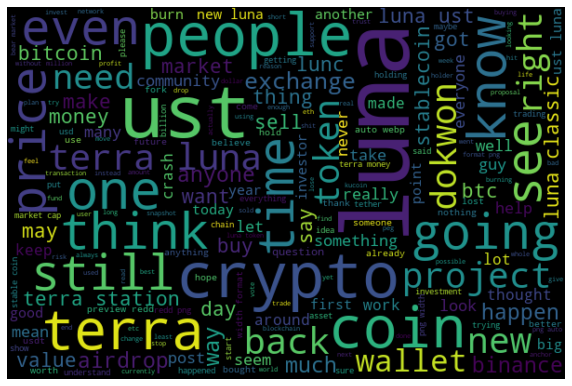

In [247]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(all_words_lem)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

In [248]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shiltonjonatansalindeho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [249]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

words = nltk.word_tokenize(all_words_lem)
fd = FreqDist(words)

In [251]:
fd.most_common(500)

[('luna', 10155),
 ('terra', 4061),
 ('ust', 3982),
 ('crypto', 2120),
 ('people', 1818),
 ('like', 1711),
 ('get', 1632),
 ('money', 1559),
 ('would', 1513),
 ('new', 1454),
 ('market', 1337),
 ('price', 1273),
 ('wallet', 1208),
 ('know', 1201),
 ('buy', 1075),
 ('time', 1064),
 ('back', 1049),
 ('coin', 1041),
 ('one', 1023),
 ('going', 974),
 ('even', 973),
 ('still', 954),
 ('think', 950),
 ('burn', 903),
 ('airdrop', 903),
 ('see', 897),
 ('binance', 871),
 ('could', 843),
 ('btc', 833),
 ('coins', 825),
 ('dokwon', 824),
 ('crash', 753),
 ('anyone', 744),
 ('also', 736),
 ('make', 735),
 ('much', 734),
 ('station', 718),
 ('classic', 717),
 ('lost', 712),
 ('bitcoin', 690),
 ('sell', 675),
 ('want', 671),
 ('may', 666),
 ('right', 647),
 ('need', 638),
 ('way', 623),
 ('many', 610),
 ('lunc', 602),
 ('token', 597),
 ('help', 592),
 ('bought', 579),
 ('got', 576),
 ('post', 569),
 ('good', 568),
 ('lot', 560),
 ('tokens', 560),
 ('worth', 558),
 ('project', 549),
 ('community', 5

In [253]:
# Obtain top 10 words
top_10 = fd.most_common(10)

# Create pandas series to make plotting easier
fdist = pd.Series(dict(top_10))

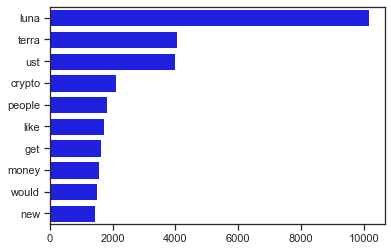

In [254]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.barplot(y=fdist.index, x=fdist.values, color='blue');

### Clean Comment Data

In [257]:
df_terraluna_comments.head()

,submission_id,parent_id,comment_id,comment,author,parent_id_clean,date
0,ultfvp,t3_ultfvp,i7yhwgn,this person just made a shit ton of money rn. ...,LSATloveaffair,ultfvp,2022-05-09
2,ultfvp,t3_ultfvp,i864dj3,and they’re rich,Dads_going_for_milk,ultfvp,2022-05-09
3,ultfvp,t3_ultfvp,i7xgukp,initially i thought this bet was interesting b...,marsangelo,ultfvp,2022-05-09
4,up76nt,t3_up76nt,i8j3fnz,it's still top 50 in marketcap because it has ...,nick83487,up76nt,2022-05-14
5,up76nt,t3_up76nt,i8j38nm,"thank you for submitting to /r/cryptocurrency,...",ccModBot,up76nt,2022-05-14


In [258]:
# Replace words meant to be together into one word

df_terraluna_comments['comment'] = df_terraluna_comments['comment'].str.replace('crypto.com', 'cryptocom')
df_terraluna_comments['comment'] = df_terraluna_comments['comment'].str.replace('do kwon', 'dokwon')
df_terraluna_comments['comment'] = df_terraluna_comments['comment'].str.replace("do kwon’s", "dokwon’s")

# Tokenize all_text

df_terraluna_comments['text_token']=df_terraluna_comments['comment'].apply(regexp.tokenize)

# Get English Stopwords
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words("english")

# Extend the list with custom stopwords
my_stopwords = ['https', 'nan', 'removed', 'amp', 'x200b', 'com', 'www', '000']
stopwords.extend(my_stopwords)

df_terraluna_comments['text_token'] = df_terraluna_comments['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
df_terraluna_comments.head()

<ipython-input-258-9dd71cc66628>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_terraluna_comments['comment'] = df_terraluna_comments['comment'].str.replace('crypto.com', 'cryptocom')
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shiltonjonatansalindeho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,submission_id,parent_id,comment_id,comment,author,parent_id_clean,date,text_token
0,ultfvp,t3_ultfvp,i7yhwgn,this person just made a shit ton of money rn. ...,LSATloveaffair,ultfvp,2022-05-09,"[person, made, shit, ton, money, rn, holy, shit]"
2,ultfvp,t3_ultfvp,i864dj3,and they’re rich,Dads_going_for_milk,ultfvp,2022-05-09,[rich]
3,ultfvp,t3_ultfvp,i7xgukp,initially i thought this bet was interesting b...,marsangelo,ultfvp,2022-05-09,"[initially, thought, bet, interesting, bet, wh..."
4,up76nt,t3_up76nt,i8j3fnz,it's still top 50 in marketcap because it has ...,nick83487,up76nt,2022-05-14,"[still, top, 50, marketcap, circulating, suppl..."
5,up76nt,t3_up76nt,i8j38nm,"thank you for submitting to /r/cryptocurrency,...",ccModBot,up76nt,2022-05-14,"[thank, submitting, r, cryptocurrency, post, c..."
